#  Imports

In [2]:
# %load_ext autoreload
# %autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

In [3]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import albumentations.pytorch as albu_pt
%matplotlib inline

import apex
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import pytorch_tools as pt

from src.dataset import OpenCitiesDataset, OpenCitiesTestDataset, InriaTilesDataset
from src.dataset import get_dataloaders
from src.augmentations import get_aug
from src.callbacks import ThrJaccardScore
from pytorch_tools.fit_wrapper.callbacks import SegmCutmix

In [4]:
import yaml
from src.utils import MODEL_FROM_NAME
from src.utils import TargetWrapper
from pytorch_tools.fit_wrapper.callbacks import Callback
from pytorch_tools.utils.misc import to_numpy
from src.utils import criterion_from_list

# Get dataloaders

In [1]:
test_dataset = OpenCitiesTestDataset()
test_loader = DataLoader(test_dataset, batch_size=16, num_workers=4)

NameError: name 'OpenCitiesTestDataset' is not defined

In [4]:
train_dtld_gpu , val_dtld_gpu = get_dataloaders(
    [
        "tier1", 
#         "tier2"
    ]
)


Using datasets: ['tier1']. Train size: 25281. Val size 4381.


In [5]:
# val_dtld_i = iter(val_dtld_gpu)
val_dtld_i = iter(train_dtld_gpu)

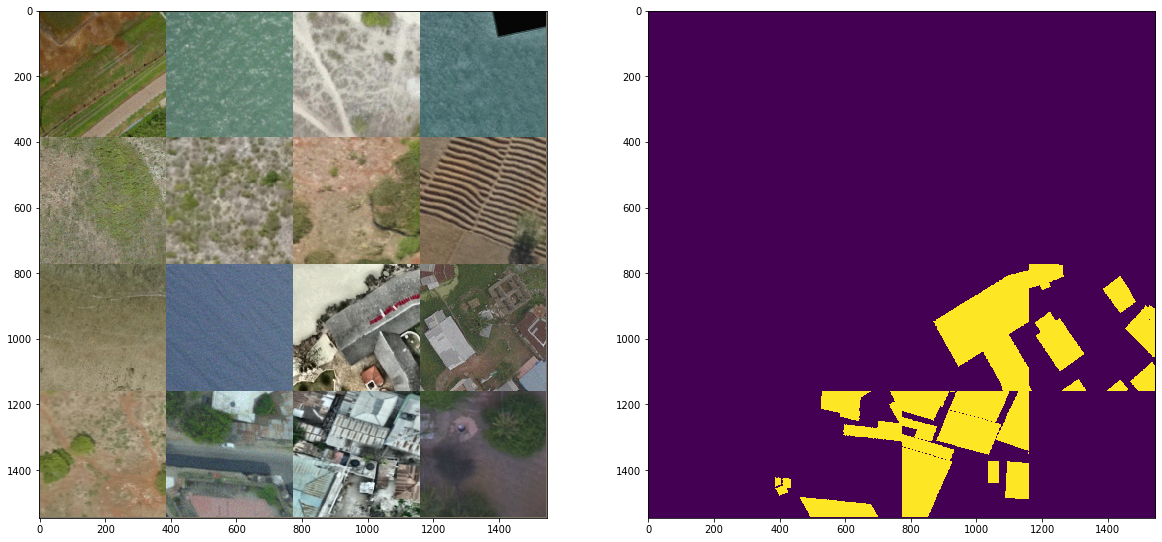

In [6]:
MEAN=(0.485, 0.456, 0.406)
STD=(0.229, 0.224, 0.225)
imgs, masks = next(val_dtld_i)
# imgs_c = imgs
# imgs = imgs_c
# imgs, masks = SegmCutmix(1, 1).cutmix(imgs, masks) # test cutmix
# (_, imgs, _), (_, masks, _) = next(test_dtld_i), next(test_dtld_i) 
# preds = torch.nn.MSELoss(reduction='none')(preds, masks)
# preds = model(imgs.cuda()).cpu().detach()
# imgs = (preds > 0).float()
# imgs = preds.sigmoid()
imgs_grid = make_grid(imgs, nrow=4).transpose(0,2)#.transpose(0,1)
masks_grid = make_grid(masks, nrow=4).transpose(0,2)#.transpose(0,1)
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
imgs_grid = to_numpy(imgs_grid) * STD + MEAN
axes[0].imshow(to_numpy(imgs_grid))
axes[1].imshow(to_numpy(masks_grid)[:,:,2]);

# Model training

In [7]:
# from bloodaxe_models import get_model as get_ba_model

In [8]:
# model = pt.segmentation_models.DeepLabV3('se_resnet50', output_stride=16, num_classes=1).cuda()
# model = pt.segmentation_models.Unet('se_resnet50', num_classes=1).cuda()
# model = get_ba_model("hrnet34_unet64").cuda()
# model = get_ba_model("resnet34_fpncat128").cuda()
# model = pt.segmentation_models.SegmentationFPN(
#     'se_resnet50', num_classes=1, merge_policy="cat",
#     encoder_weights=None, antialias=True, deep_stem=True, 
# ).cuda()
model = pt.segmentation_models.SegmentationBiFPN('se_resnet50', num_fpn_layers=2, merge_policy="cat").cuda()
# optim = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
optim = apex.optimizers.FusedNovoGrad(model.parameters(), weight_decay=1e-4, set_grad_none=False)
model, optim = apex.amp.initialize(model, optim, verbosity=0, loss_scale=2048)
# freeze encoder
# for p in model.encoder.parameters():
#     p.requires_grad = False
pt.utils.misc.count_parameters(model)

(29877782, 29877782)

In [9]:
# log_path = "logs/2.deeplab_nov_warmup_20200212_171523/"
# model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"], strict=False)

In [11]:
# loss = pt.losses.CrossEntropyLoss(mode="binary").cuda()
# loss = pt.losses.DiceLoss(mode="binary").cuda()
# loss = 0.5 * pt.losses.CrossEntropyLoss(mode="binary").cuda() + 0.5 * loss
# loss = 0.5 * loss + 0.5 * pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.LovaszLoss().cuda() + 4 * pt.losses.BinaryFocalLoss().cuda() 
# loss = pt.losses.BinaryHinge().cuda()
# loss = ThrMSELoss() #torch.nn.MSELoss()
# loss = torch.nn.L1Loss()
loss = criterion_from_list(["whinge", 1])

In [12]:
bce_metric = pt.losses.CrossEntropyLoss(mode="binary").cuda()
bce_metric.name = "BCE"
bce_metric = TargetWrapper(bce_metric, "mask")

In [13]:
runner = pt.fit_wrapper.Runner(
    model, 
    optim, 
    criterion=loss, # pt.losses.BinaryHinge(), 
    callbacks=[
#         pt.fit_wrapper.callbacks.Timer(),
        pt.fit_wrapper.callbacks.ConsoleLogger(), 
#         pt.fit_wrapper.callbacks.SegmCutmix(),
#         PatchTarget(), # needed for bloodaxe models
#         pt.fit_wrapper.callbacks.ReduceLROnPlateau(10),
#         pt.fit_wrapper.callbacks.FileLogger('/tmp/')
    ],
    metrics=[
        TargetWrapper(pt.metrics.JaccardScore(mode="binary"), "mask"),
        bce_metric, 
        TargetWrapper(ThrJaccardScore(thr=0.5), "mask"),
    ],
)

In [18]:
# freeze encoder
for p in model.encoder.parameters():
    p.requires_grad = False

In [19]:
# imgs, masks = next(iter(val_dtld_gpu))
# pred = model(imgs)
# imgs.dtype, masks.dtype, imgs.shape, masks.shape, pred.shape

In [20]:
runner.fit(val_dtld_gpu, epochs=10) #, val_loader=val_dtld_inria_gpu, epochs=1)

Epoch  1/10. training: 275it [00:33,  8.31it/s, BCE=0.605, Jaccard=0.122, Loss=0.9215, ThrJaccard@0.5=0.215]             
Epoch  2/10. training: 275it [00:32,  8.35it/s, BCE=0.392, Jaccard=0.187, Loss=0.4279, ThrJaccard@0.5=0.400]             
Epoch  3/10. training: 275it [00:32,  8.36it/s, BCE=0.337, Jaccard=0.214, Loss=0.3479, ThrJaccard@0.5=0.465]             
Epoch  4/10. training: 275it [00:32,  8.41it/s, BCE=0.314, Jaccard=0.230, Loss=0.3120, ThrJaccard@0.5=0.498]             
Epoch  5/10. training: 275it [00:32,  8.37it/s, BCE=0.298, Jaccard=0.242, Loss=0.2895, ThrJaccard@0.5=0.515]             
Epoch  6/10. training: 275it [00:32,  8.37it/s, BCE=0.286, Jaccard=0.251, Loss=0.2740, ThrJaccard@0.5=0.527]             
Epoch  7/10. training: 275it [00:32,  8.33it/s, BCE=0.275, Jaccard=0.258, Loss=0.2621, ThrJaccard@0.5=0.537]             
Epoch  8/10. training: 275it [00:32,  8.37it/s, BCE=0.267, Jaccard=0.265, Loss=0.2523, ThrJaccard@0.5=0.545]             
Epoch  9/10. training: 2

In [21]:
for p in model.parameters():
    p.requires_grad = True

In [55]:
runner.fit(val_dtld_gpu, epochs=10)

Epoch  1/10. training: 275it [00:48,  5.69it/s, BCE=0.136, Jaccard=0.408, Loss=0.0918, ThrJaccard@0.5=0.759]             
Epoch  2/10. training: 275it [00:48,  5.70it/s, BCE=0.125, Jaccard=0.428, Loss=0.0846, ThrJaccard@0.5=0.772]             
Epoch  3/10. training: 275it [00:48,  5.70it/s, BCE=0.118, Jaccard=0.441, Loss=0.0787, ThrJaccard@0.5=0.785]             
Epoch  4/10. training: 275it [00:48,  5.68it/s, BCE=0.119, Jaccard=0.437, Loss=0.0750, ThrJaccard@0.5=0.791]             
Epoch  5/10. training: 275it [00:48,  5.67it/s, BCE=0.110, Jaccard=0.455, Loss=0.0699, ThrJaccard@0.5=0.801]             
Epoch  6/10. training: 275it [00:48,  5.72it/s, BCE=0.108, Jaccard=0.460, Loss=0.0662, ThrJaccard@0.5=0.811]             
Epoch  7/10. training: 275it [00:48,  5.70it/s, BCE=0.103, Jaccard=0.472, Loss=0.0627, ThrJaccard@0.5=0.818]             
Epoch  8/10. training: 275it [00:48,  5.68it/s, BCE=0.102, Jaccard=0.473, Loss=0.0601, ThrJaccard@0.5=0.824]             
Epoch  9/10. training:  

KeyboardInterrupt: 

# Results examination

In [9]:
# log_path = "logs/fpn_sm_cat_seresnet50_20200208_190143/"
# log_path = "logs/fpn_sm_20200205_165954/" # 0.71 on LB. 0.67 on local per image
# log_path = "logs/deeplab_small_dilation_seresnet50_20200209_112059/" # 0.72 on local val
# log_path = "logs/fpn_nov_bce_dice_seresnet50_20200209_235106/"
# log_path = "logs/3.segm_fpn_nov_hinge_seresnet50_warmup_20200213_160637/"
log_path = "logs/5.deeplab_hinge_clip_mae_bce_warmup_20200226_221955/"
config = yaml.load(open(log_path + "config.yaml"))
model = MODEL_FROM_NAME[config["segm_arch"]](config["arch"], **config.get("model_params", {})).cuda()
print("model loaded")
model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"], strict=False)

model loaded


<All keys matched successfully>

In [10]:
# torch.onnx.export(model, torch.ones(1, 3, 256, 256).cuda(), "model.onnx")

In [11]:
model = apex.amp.initialize(model, verbosity=0)

In [12]:
val_dtld = DataLoader(val_dtst, batch_size=1, shuffle=False, num_workers=2, drop_last=True)
val_dtld_gpu = ToCudaLoader(val_dtld)

In [13]:
# val_dtld = DataLoader(val_dtst, batch_size=16, shuffle=False, num_workers=4, drop_last=True)
# val_dtld_gpu = ToCudaLoader(val_dtld)

In [14]:
class ResultsHist(Callback):
    """Saves all values of loss"""
    def __init__(self):
        super().__init__()
        self.res = []
        
    def on_batch_end(self):
        data, target = self.state.input
        output = self.state.output
        loss = self.state.metrics[0](output, target)
        self.res.append(to_numpy(loss))
    
    def on_loader_end(self):
        self.res = np.array(self.res)
        
class PredSaver(Callback):
    """Saves best and worse predicts"""
    def __init__(self, best_thr=0.9, worst_thr=0.2, filter_empty=True):
        super().__init__()
        self.best_img = []
        self.best_target = []
        self.best_preds = []
        self.best_metric = []
        
        self.worst_img = []
        self.worst_target = []
        self.worst_preds = []
        self.worst_metric = []
        
        self.best_thr = best_thr
        self.worst_thr = worst_thr
        self.filter_empty = filter_empty
        
    def on_batch_end(self):
        data, target = self.state.input
        output = self.state.output
        metric = self.state.metrics[0](output, target)
        metric = to_numpy(metric)
        if metric > self.best_thr:
            if self.filter_empty and to_numpy(target).sum() == 0:
                return 
            self.best_img.append(to_numpy(data))
            self.best_target.append(to_numpy(target))
            self.best_preds.append(to_numpy(output))
            self.best_metric.append(metric)
        
        if metric < self.worst_thr:
            self.worst_img.append(to_numpy(data))
            self.worst_target.append(to_numpy(target))
            self.worst_preds.append(to_numpy(output))
            self.worst_metric.append(metric)
#         self.res.append(pt.utils.misc.to_numpy(metric))
    
    def on_loader_end(self):
        if len(self.worst_img) > 0:
            self.worst_img = np.swapaxes(np.array(self.worst_img).squeeze(), 1, 3)
            self.worst_img = np.swapaxes(self.worst_img, 1, 2)
            self.worst_target = np.array(self.worst_target).squeeze()
            self.worst_preds = np.array(self.worst_preds).squeeze()
            self.worst_metric = np.array(self.worst_metric)
        
        if len(self.best_img) > 0:
            self.best_img = np.swapaxes(np.array(self.best_img).squeeze(), 1, 3)
            self.best_img = np.swapaxes(self.best_img, 1, 2)
            self.best_target = np.array(self.best_target).squeeze()
            self.best_preds = np.array(self.best_preds).squeeze()
            self.best_metric = np.array(self.best_metric)
    
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

In [15]:
hinge_metric = pt.losses.BinaryHinge()
hinge_metric.name = "Hinge"

In [16]:
loss = TargetWrapper(pt.losses.JaccardLoss(), "mask")
results_hist = ResultsHist()
pred_saver = PredSaver(worst_thr=0.02, best_thr=0.3)
runner = pt.fit_wrapper.Runner(
    model, 
    None, 
    criterion=loss,
    callbacks=[
        pt.fit_wrapper.callbacks.ConsoleLogger(),
        results_hist,
        pred_saver,
    ],
    metrics=[
        TargetWrapper(hinge_metric, "mask"),
        TargetWrapper(ThrJaccardScore(thr=0.5), "mask"),
#         hinge_metric,
#         bce_metric,
        TargetWrapper(pt.metrics.JaccardScore(mode="binary"), "mask"),
        
#         ThrJaccardScore(thr=0.3),
#         ThrJaccardScore(thr=0.4),
    ]
)
runner.evaluate(val_dtld_gpu)

Epoch  1/1. validating: 4382it [02:15, 32.45it/s, Hinge=0.090, Jaccard=0.817, Loss=0.1832, ThrJaccard@0.5=0.876]              


(0.18322157382257614,
 [0.09028848689499752, 0.8761159558868713, 0.8167784261774239])

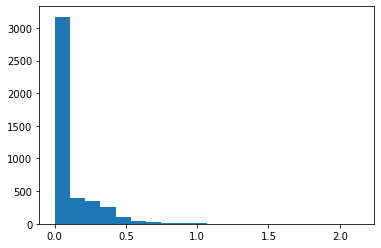

In [17]:
plt.hist(results_hist.res, bins=20);

In [18]:
len(pred_saver.worst_preds), len(pred_saver.best_preds)

(2832, 526)

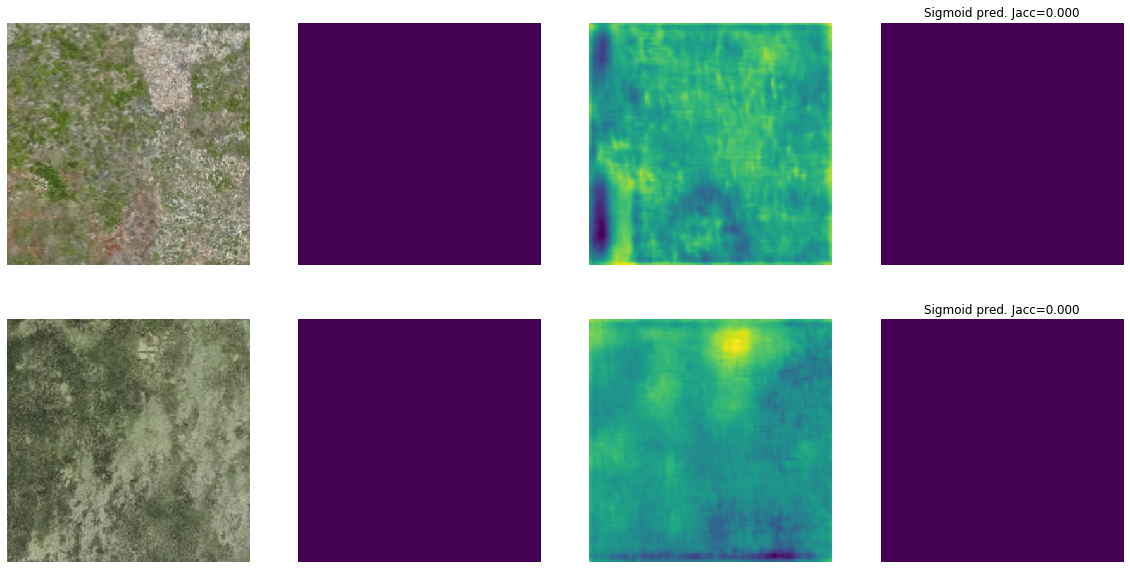

In [20]:
# Worst predictions
N_ROW = 2
fig, axes = plt.subplots(N_ROW, 4, figsize=(20, 10))
for i in axes:
    for j in i:
        j.axis('off')
for i in range(N_ROW):
    N = np.random.randint(0, len(pred_saver.worst_preds))
    img = pred_saver.worst_img[N] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    img = (img * 255).astype(np.uint8)
    pred = pred_saver.worst_preds[N]
    axes[i][0].imshow(img)
    axes[i][1].imshow(pred_saver.worst_target[N][2])
    axes[i][2].imshow(pred)
    axes[i][3].imshow(sigmoid(pred_saver.worst_preds[N]) > 0.5)
#     axes[i][3].imshow(pred_saver.worst_preds[N] > 0.5)
    axes[i][3].set_title(f"Sigmoid pred. Jacc={pred_saver.worst_metric[N]:.03f}")
    

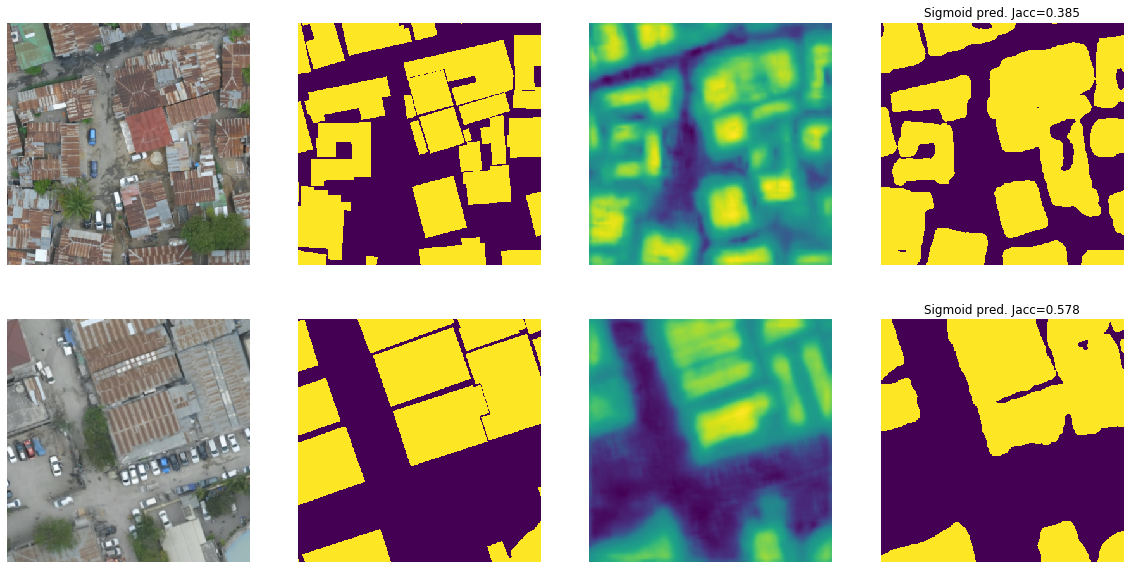

In [26]:
# Best predictions
N_ROW = 2
fig, axes = plt.subplots(N_ROW, 4, figsize=(20, 10))
for i in axes:
    for j in i:
        j.axis('off')
for i in range(N_ROW):
    N = np.random.randint(0, len(pred_saver.best_preds))
    img = pred_saver.best_img[N] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    img = (img * 255).astype(np.uint8)
    pred = pred_saver.best_preds[N]
    axes[i][0].imshow(img)
    axes[i][1].imshow(pred_saver.best_target[N][2])
    axes[i][2].imshow(pred)
    axes[i][3].imshow(sigmoid(pred_saver.best_preds[N]) > 0.5)
    axes[i][3].set_title(f"Sigmoid pred. Jacc={pred_saver.best_metric[N]:.03f}")
    

# Better Results examination

In [ ]:
# PREV_WEIGHTS = None
# PREV_IMGS_MASKS_PREDS = None

# @interact(N=(0, 7), weights=sorted(os.listdir("../jewels_train/logs/")))
# def foo(N, weights=None):
#     global PREV_WEIGHTS
#     global PREV_IMGS_MASKS_PREDS
    
#     if weights is None:
#         print("select weights")
#         return 
    
#     if weights != PREV_WEIGHTS:
# #         print("loading")
#         PREV_WEIGHTS = weights
#         log_path = "../jewels_train/logs/" + weights + "/"
#         config = yaml.load(open(log_path + "FLAGS.yaml"))
#         model = NAME_TO_MODEL[config["segm_arch"]](config["arch"], in_channels=config["num_images"], encoder_weights=None, **config.get("model_params", {})).cuda()
#         model.load_state_dict(torch.load(log_path + 'model.chpn')["state_dict"], strict=False)
#         val_loader = PyTorchDALIWrapper(
#             5 if config["use_diff"] else 4, 
#             data_dir='/home/zakirov/datasets/kamni_clear/old_val/', 
#             train=False, 
#             crop_size=512, 
#             batch_size=8,
#             use_diff=config["use_diff"],
#         )
#         imgs, masks = next(iter(val_loader))
#         with torch.no_grad():
#             preds = model(imgs).sigmoid()
#         del model
#         del val_loader
#         PREV_IMGS_MASKS_PREDS = (imgs, masks, preds)
        
        
#     (IMGS, MASKS, PREDS) = PREV_IMGS_MASKS_PREDS
#     if True:
#         diff = to_numpy(IMGS[N, 3]) 
#         diff = (diff + 1) * 0.5
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#         diff = clahe.apply((diff * 255).astype(np.uint8)) / 255
#     else:
#         diff = to_numpy(imgs[N, :3])
#     mask = to_numpy(MASKS[N, 0])
#     pred = to_numpy(PREDS[N, 0])
#     stacked = np.hstack([diff, mask, pred])
#     plt.figure(figsize=(30,10))
#     plt.imshow(stacked, cmap="gray")
#     plt.axis("off")

# Test CRF

In [33]:
import morphsnakes as ms

In [34]:
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [35]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray_img)

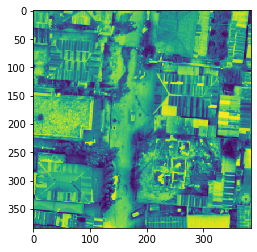

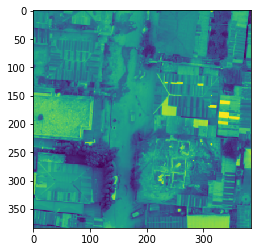

In [36]:
plt.imshow(cl1)
plt.show()
plt.imshow(gray_img)

In [37]:
gray_img.max()

252

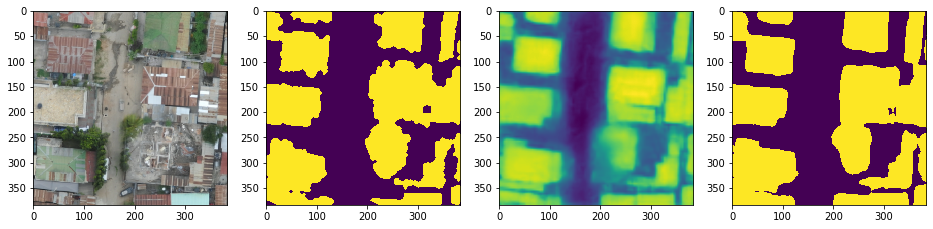

In [44]:
ac_pred = ms.morphological_chan_vese(gray_img, iterations=10, 
                                         init_level_set=pred,
#                                          init_level_set="checkerboard",
                                         smoothing=2, #threshold=0.31,
#                                          balloon=1
#                                          lambda1=0.5,
#                                          lambda2=2,
                                    )

fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
axes[0].imshow(img)
axes[1].imshow(ac_pred)
axes[2].imshow(pred)
axes[3].imshow(sigmoid(pred) > 0.5)

# Looking for bugs

In [98]:
def binary_hinge(y_pred, y_true, margin=1, pos_weight=1.):
    """
    Implements Hinge loss.
    Args:
        y_pred (torch.Tensor): of shape `Nx*` where * means any number
             of additional dimensions
        y_true (torch.Tensor): same shape as y_pred
        margin (float): margin for y_pred after which loss becomes 0. 
    """
    y_pred = y_pred.view(y_pred.size(0), -1)
    y_true = y_true.view(y_true.size(0), -1)
    y_true_shifted = 2 * y_true - 1  # [target == 0] = -1
    hinge = torch.nn.functional.relu(margin - y_pred * y_true_shifted)
    hinge *= y_true * pos_weight + (1 - y_true) * 1
    return hinge.mean()  # reduction == mean


In [85]:
y_pred = torch.randint(0, 2, (2, 1, 8, 8))
y_true = torch.ones(2, 1, 8, 8)
y_true[0] = 0

In [86]:
y_true

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1.]]]])

In [87]:
y_pred

tensor([[[[1, 1, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 1, 1, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 1, 1, 1, 0, 0],
          [0, 0, 0, 1, 0, 0, 1, 0],
          [0, 0, 0, 0, 0, 0, 1, 0],
          [1, 0, 0, 1, 1, 1, 0, 0],
          [1, 1, 1, 0, 0, 1, 0, 0]]],


        [[[1, 0, 1, 0, 1, 1, 0, 1],
          [1, 1, 1, 1, 0, 1, 0, 1],
          [1, 1, 0, 0, 0, 1, 1, 0],
          [1, 1, 1, 0, 1, 1, 0, 1],
          [1, 1, 1, 1, 1, 1, 1, 0],
          [0, 1, 1, 1, 0, 1, 1, 1],
          [0, 1, 1, 0, 0, 1, 0, 0],
          [0, 1, 1, 0, 0, 1, 1, 1]]]])

In [ ]:
torch.gather()

In [52]:
y_pred_r = y_pred.view(y_pred.size(0), -1)
y_true_r = y_true.view(y_true.size(0), -1)

In [53]:
y_true_r = 2 * y_true_r - 1  # [target == 0] = -1

In [55]:
torch.nn.functional.relu(1 - y_pred_r * y_true_r)

tensor([[1., 2., 1., 1., 1., 1., 2., 1., 2., 2., 2., 2., 1., 1., 2., 1., 2., 1.,
         2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2., 1., 2., 2., 1., 1., 1., 2.,
         2., 2., 1., 2., 1., 1., 1., 1., 2., 2., 1., 2., 2., 1., 2., 1., 1., 2.,
         2., 1., 1., 2., 2., 1., 2., 2., 2., 1.],
        [1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
         0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
         1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
         0., 0., 0., 1., 0., 1., 1., 1., 1., 1.]])

In [101]:
binary_hinge(y_pred, y_true, pos_weight=1)

tensor(0.8359)

In [102]:
pt.losses.functional.binary_hinge(y_pred, y_true)

tensor(0.8359)